In [ ]:
#all_no_test
import os
import time
import json
import math
from typing import Callable
from functools import reduce
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm.callback import record_evaluation, CallbackEnv, EarlyStopException, _format_eval_result
from lightgbm.basic import _log_info
from opt_utils import *

os.system('pip install neptune-client')
os.system('pip install neptune-lightgbm')
import neptune.new as neptune
from neptune.new.integrations.lightgbm import create_booster_summary
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
NEPTUNE_API_TOKEN = user_secrets.get_secret("NEPTUNE_API_TOKEN")

# Callback for dart earlystopping
def early_stopping_dart(dart_dict: dict, stopping_rounds: int=None, model_file: str=None) -> Callable:
    """Create a callback that saves the model with the best validation score at ``model_file``, 
    and stops training if there ``stopping_rounds`` without improvement.

    Parameters
    ----------
    dart_dict : dict
        A dictionary to save the best iteration, train score, and valid score of that iteration
    stopping_rounds : int 
        The possible number of rounds without the score improving.
    model_file : str
        Path used to save the best scoring model.

    Returns
    -------
    callback : callable
        The callback that saves the best scoring model to file, and collects 
        best iteration, train score, and valid score.
    """
    
    stopping_rounds = dart_dict.get('stopping_rounds', stopping_rounds)
    model_file = dart_dict.get('model_file', model_file)
    best_score = [math.inf]
    best_iter = [0]
    
    def _callback(env: CallbackEnv) -> None:
        score = env.evaluation_result_list[-1][2]
        if score < best_score[0]: 
            best_score[0] = score
            env.model.save_model(model_file)
            dart_dict['best_iteration'] = best_iter[0] = env.iteration
            dart_dict['train_score'] = score
            dart_dict['valid_score'] = env.evaluation_result_list[1][2]
            
        if env.iteration - best_iter[0] >= stopping_rounds:
            _log_info(f"Early stopping, best iteration is:\n[{best_iter[0] + 1}]\t{best_score[0]}")
            raise EarlyStopException(best_iter[0], env.evaluation_result_list)
            
    return _callback

In [ ]:
cfg = {
    "script_name": 'opt_train_v2_op_89',
    "path_features": '../input/generate-train-features-script-p13/p13_train.pkl', # Used in train mode
    "path_models": '',
    "path_data_raw": '../input/optiver-realized-volatility-prediction/',
    "neptune_project": 'chrisrichardmiles/optiver',
    "neptune_description": 'p13 encoding top columns with shake .3',
    "encode_time_cols": ['real_vol_ratio_5_10', 'real_vol_mean_decay_0.9_-1', 'order_norm_momentum', 'real_vol_mean_decay_0.85_-1', 'real_vol_mean_decay_0.99_1', 'real_vol_mean_decay_0.95_1', 'abs_price_wap_diff_mean_decay_flip', 'abs_price_wap_diff_mean_decay', 'order_norm_sum', 'real_vol_mean_decay_0.85_-1_2', 'spread_mean_decay_flip_95', 'real_vol_mean_decay_0.99_-1', 'real_vol_mean_decay_0.75_-1', 'spread_mean', 'order_count_sum', 'bid_price_diff_count_unique', 'spread_momentum', 'size_mean', 'real_vol_mean_decay_0.95_-1', 'order_norm_mean_decay', 'spread_2_mean_decay_95', 'order_size_mean', 'spread_mean_decay_95', 
                         'spread_pct_momentum'], 
    "encode_stock_cols": ['real_vol_ratio_5_10', 'real_vol_mean_decay_0.9_-1', 'order_norm_momentum', 'real_vol_mean_decay_0.85_-1', 'real_vol_mean_decay_0.99_1', 'real_vol_mean_decay_0.95_1', 'abs_price_wap_diff_mean_decay_flip', 'abs_price_wap_diff_mean_decay', 'order_norm_sum', 'real_vol_mean_decay_0.85_-1_2', 'spread_mean_decay_flip_95', 'real_vol_mean_decay_0.99_-1', 'real_vol_mean_decay_0.75_-1', 'spread_mean', 'order_count_sum', 'bid_price_diff_count_unique', 'spread_momentum', 'size_mean', 'real_vol_mean_decay_0.95_-1', 'order_norm_mean_decay', 'spread_2_mean_decay_95', 'order_size_mean', 'spread_mean_decay_95',
                          'spread_pct_momentum'], 
    "drop_cols": ['row_id', 'time_id', 'stock_id', 'target'] + ['real_momentum_0.55_-1', 'wap_2_last-first', 'sum_bid_ask_momentum', 'abs_log_return_momentum', 'order_size_sqaure_weighted_sum', 'size_mean_decay_95', 'size_norm_momentum_95', 'size_norm_momentum', 'size_spread_mean_decay_flip_95', 'log_return_2_realized_volatility', 'abs_price_wap_diff_2_std', 'sum_bid_ask_mean', 'real_momentum_0.85_-1', 'real_vol_mean_decay_0.55_-1', 'abs_price_wap_diff_amax', 'size_mean_decay', 'real_vol_mean_decay_0.9_-1_2', 'abs_price_wap_diff_2_mean', 'real_momentum_0.65_-1_2', 'price_wap_diff_2_max_sub_min', 'real_vol_mean_decay_0.75_1', 'real_vol_min_5', 'real_vol_mean_decay_0.95_-1_2', 'real_vol_min_6', 'size_spread_mean', 'size_spread_mean_decay_95', 'real_vol_mean_decay_0.75_1_2', 'sum_bid_ask_std', 'price_wap_diff_mean_decay', 'wap_2_real_vol', 'abs_price_wap_diff_2_mean_decay', 'size_momentum_95', 'real_momentum_0.65_-1', 'size_spread_momentum_95', 'real_vol_min_2', 'sum_bid_ask_mean_decay_flip', 'real_vol_mean_decay_0.65_1', 'size_spread_mean_decay_flip', 'real_momentum_0.75_-1_2', 'abs_price_wap_diff_2_max_sub_min', 'price_wap_diff_momentum', 'real_momentum_0.55_-1_2', 'real_momentum_0.45_-1_2', 'spread_pct_std', 'abs_price_wap_diff_max_sub_min', 'real_momentum_0.95_-1', 'real_vol_min_7', 'real_vol_min_4_2', 'real_vol_mean_decay_0.99_1_2', 'spread_2_sum', 'sum_bid_ask_mean_decay', 'real_vol_mean_decay_0.55_1', 'real_vol_mean_decay_0.55_1_2', 'real_vol_mean_decay_0.9_1_2', 'real_vol_mean_decay_0.65_1_2', 'real_vol_mean_decay_0.45_1_2', 'wap_2_std', 'price_wap_diff_max_sub_min', 'real_momentum_0.85_-1_2', 'real_momentum_0.45_-1', 'price_wap_diff_2_mean_decay_flip', 'size_norm_mean_decay_flip_95', 'price_wap_diff_mean_decay_flip', 'real_momentum_0.99_-1', 'sum_bid_ask_max_sub_min', 'real_vol_mean_decay_0.95_1_2', 'real_vol_min_4', 'real_vol_min_8', 'real_vol_min_2_2', 'real_momentum_0.99_-1_2', 'real_momentum_0.95_-1_2', 'log_return_mean_decay_flip', 'real_vol_mean_decay_0.85_1_2', 'price_wap_diff_2_std', 'log_return_realized_volatility', 'abs_log_return_2_momentum', 'log_return_2_mean_decay_flip', 'log_return_std', 'log_return_2_std', 'real_momentum_0.75_-1', 'real_vol_mean_decay_0.45_-1_2', 'abs_price_wap_diff_2_momentum', 'real_momentum_0.9_-1_2', 'real_vol_mean_decay_0.9_1', 'price_wap_diff_2_mean_decay', 'real_vol_min_9_2', 'real_vol_mean_decay_0.99_-1_2', 'wap_2_max_sub_min', 'real_momentum_0.9_-1', 'dummy3', 'abs_price_wap_diff_2_mean_decay_flip', 
                                                               'abs_log_return_2_std'],
    "encode_funcs": ['mean', 'std'], 
    "shake": False, 
    "shake_std": .3, 
    "prefix": '',
    "rerun": True,
    "neptune_run_name": '',
    "lgb_params": {
        # https://lightgbm.readthedocs.io/en/latest/index.html
        "boosting_type": "dart",
        "objective": "rmse",
        "learning_rate": .05,
        "num_leaves": 255,
        "min_data_in_leaf": 255,
        "feature_fraction": 0.8,
        "bagging_fraction": .5, # Select bagging_fraction of rows every bagging_freq of iterations.
        "bagging_freq": 1,      # This speeds up training and underfits. Need both set to do anything.
        "n_estimators": 3,
        "early_stopping_rounds": 400,
        "n_jobs": -1,
        "seed": 42,
        "verbose": -1, 
    },
}
with open('cfg.json', 'w') as f: 
    json.dump(cfg, f)

Training fold 0


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	train's rmse: 0.00114413	train's RMSPE: 0.52998	valid's rmse: 0.00115188	valid's RMSPE: 0.53124


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[2]	train's rmse: 0.00109769	train's RMSPE: 0.508467	valid's rmse: 0.00110573	valid's RMSPE: 0.509958
[3]	train's rmse: 0.00105382	train's RMSPE: 0.488149	valid's rmse: 0.00106222	valid's RMSPE: 0.48989
2
Training fold 1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	train's rmse: 0.0011456	train's RMSPE: 0.52913	valid's rmse: 0.00114536	valid's RMSPE: 0.534346


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[2]	train's rmse: 0.00109882	train's RMSPE: 0.507522	valid's rmse: 0.00109936	valid's RMSPE: 0.512882
[3]	train's rmse: 0.00105481	train's RMSPE: 0.487196	valid's rmse: 0.00105636	valid's RMSPE: 0.492825
2
Training fold 2


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	train's rmse: 0.00114983	train's RMSPE: 0.531413	valid's rmse: 0.00112919	valid's RMSPE: 0.52551


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[2]	train's rmse: 0.00110306	train's RMSPE: 0.509799	valid's rmse: 0.0010835	valid's RMSPE: 0.504245
[3]	train's rmse: 0.00105898	train's RMSPE: 0.489427	valid's rmse: 0.00104054	valid's RMSPE: 0.484253
2
Training fold 3


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	train's rmse: 0.001147	train's RMSPE: 0.530741	valid's rmse: 0.00114036	valid's RMSPE: 0.528187


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[2]	train's rmse: 0.00110018	train's RMSPE: 0.509077	valid's rmse: 0.00109398	valid's RMSPE: 0.506709
[3]	train's rmse: 0.00105622	train's RMSPE: 0.488736	valid's rmse: 0.00105007	valid's RMSPE: 0.48637
2
Training fold 4


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	train's rmse: 0.0011412	train's RMSPE: 0.529605	valid's rmse: 0.00116322	valid's RMSPE: 0.532431


/opt/conda/lib/python3.7/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[2]	train's rmse: 0.00109532	train's RMSPE: 0.508314	valid's rmse: 0.00111604	valid's RMSPE: 0.510835
[3]	train's rmse: 0.00105181	train's RMSPE: 0.488118	valid's rmse: 0.00107131	valid's RMSPE: 0.490362
2
Our out of folds RMSPE is 0.4887
Our cv fold scores are [0.49, 0.493, 0.484, 0.486, 0.49]
https://app.neptune.ai/chrisrichardmiles/optiver/e/OP-125
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 142 operations to synchronize with Neptune. Do not kill this process.


All 142 operations synced, thanks for waiting!
retraining model with all data for [2, 2, 2, 2, 2] iterations


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


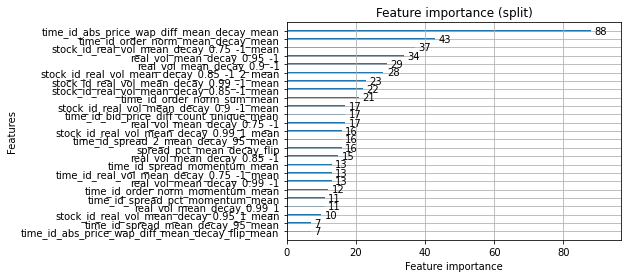

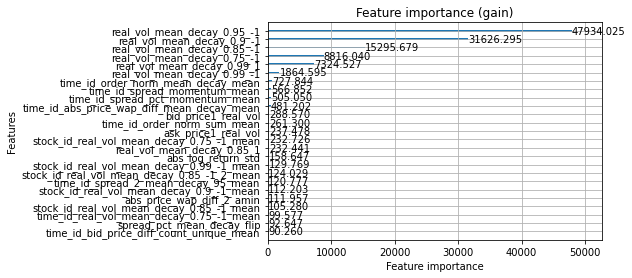

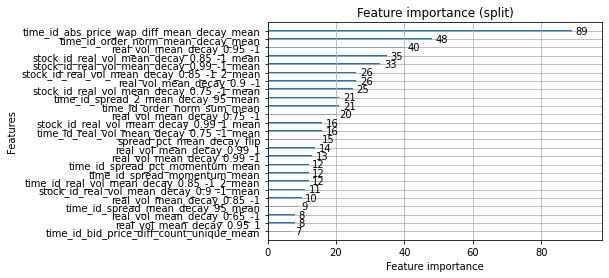

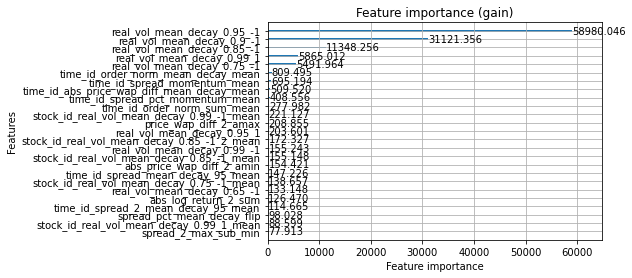

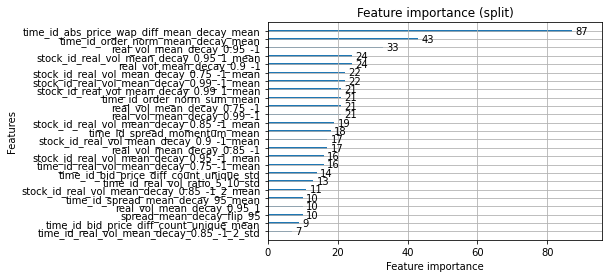

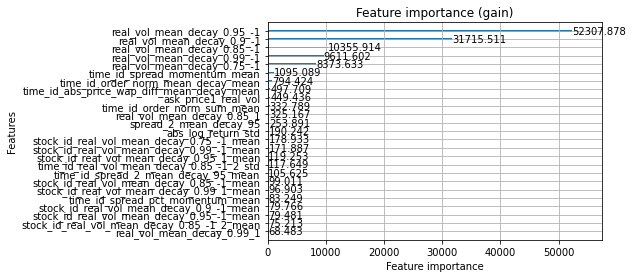

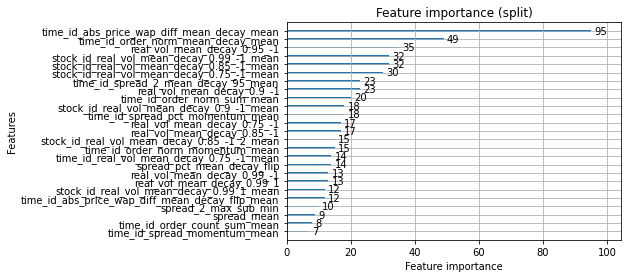

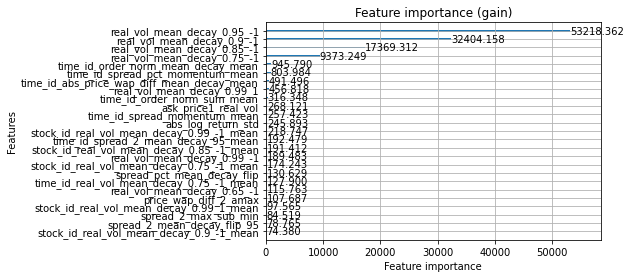

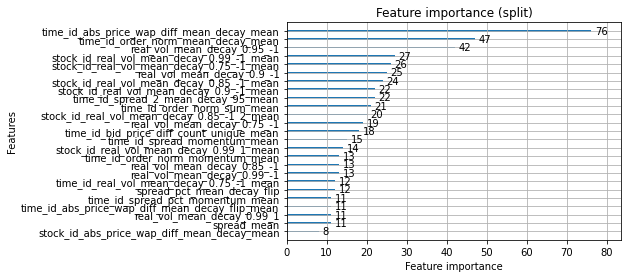

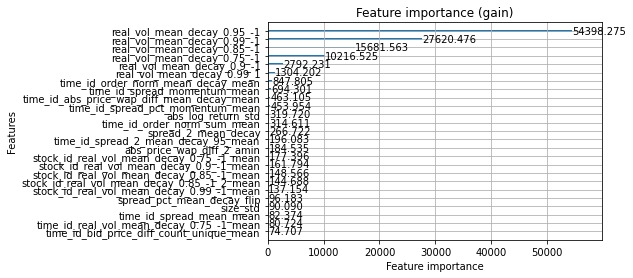

In [ ]:
def main(): 
    train = pd.read_pickle(cfg['path_features'])
    train['real_vol_ratio_5_10'] = train[[f'real_vol_min_{i}' for i in range(1, 6)]].sum(axis=1) / train[[f'real_vol_min_{i}' for i in range(6, 11)]].sum(axis=1)
    train = encode_cols(train, cfg["encode_time_cols"], funcs=cfg['encode_funcs'], on='time_id')

    # Saving encoded stock columns
    feat_file = 'enc_' + os.path.split(cfg['path_features'])[1]
    tmp = encode_cols(train, cfg["encode_stock_cols"], funcs=cfg['encode_funcs'], on='stock_id')
    tmp.to_pickle(os.path.join(cfg['path_models'], feat_file))
    del tmp

    drop_cols = [c for c in cfg['drop_cols'] if c in train.columns and c != 'stock_id']
    x = train.drop(drop_cols, axis = 1)
    y = train['target']

    oof_predictions = np.zeros(x.shape[0]) # Create out of folds array
    scores = [] # Keep track of scores for each fold and all oof at the end
    best_iterations = []
    training_best_scores = []
    valid_best_scores = [] # Same as scores in this script, but would be different with nested cv
    best_score_diffs = []
    dict_eval_logs = [] # For experimentation tracking
    booster_summaries = [] # For experimentation tracking
    dumb_features = []
    top_features = []

    for fold in range(5):
        
        trn_ind = x.fold != fold
        val_ind = x.fold == fold

        print(f'Training fold {fold}')
        x_train, x_val = x[trn_ind].drop('fold', axis=1), x[val_ind].drop('fold', axis=1)
        y_train, y_val = y[trn_ind], y[val_ind]

        x_train = encode_cols(x_train, 
                              cfg['encode_stock_cols'], 
                              funcs=cfg['encode_funcs'], 
                              shake=cfg['shake'], 
                              shake_std=cfg['shake_std']).drop('stock_id', axis=1)
        n_train_cols = x_train.shape[1]

        x_val = encode_cols(x_val, 
                            cfg['encode_stock_cols'], 
                            funcs=cfg['encode_funcs']).drop('stock_id', axis=1)

        train_weights = 1 / np.square(y_train) # Root mean squared percentage error weights
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight=train_weights, free_raw_data=False)
        val_dataset = lgb.Dataset(x_val, y_val, weight=val_weights, reference=train_dataset, free_raw_data=False)

        # Variables for callback functions
        
        model_file = os.path.join(cfg['path_models'], f'{cfg["prefix"]}lgb_fold_{fold}.txt')
        dart_dict = {'stopping_rounds': cfg['lgb_params']['early_stopping_rounds'],
                     'model_file': model_file}
        dict_eval_log = {}
        

        model = lgb.train(params = cfg['lgb_params'], 
                          train_set = train_dataset, 
                          valid_sets = [val_dataset, train_dataset], 
                          valid_names = ['valid', 'train'], 
                          feval = feval_rmspe,
                          callbacks=[record_evaluation(dict_eval_log), 
                                     early_stopping_dart(dart_dict)],
                          verbose_eval = 1)

        model = lgb.Booster(model_file=model_file)
        y_pred = model.predict(x_val)
        oof_predictions[val_ind] = y_pred
        scores.append(round(rmspe(y_val, y_pred), 3))

        dumb_features.append(get_dumb_features(model))
        top_features.append(get_top_features(model))

        booster_summary = create_booster_summary(
            booster=model,
            log_importances=True,
            max_num_features=25,
            log_trees_as_dataframe=False, 
            log_pickled_booster=True, 
            y_true=y_val, 
            y_pred=y_pred, 
        )
        
        train_score = dart_dict['train_score']
        valid_score = dart_dict['valid_score']
        print(dart_dict['best_iteration'])
        best_iterations.append(dart_dict['best_iteration'])
        training_best_scores.append(round(train_score, 3))
        valid_best_scores.append(round(valid_score, 3))
        best_score_diffs.append(round(valid_score - train_score, 3))

        booster_summaries.append(booster_summary)
        dict_eval_logs.append(dict_eval_log)
        del booster_summary, dict_eval_log

    rmspe_score = round(rmspe(y, oof_predictions), 4)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    print(f'Our cv fold scores are {scores}')
    np.save('oof_predictions', oof_predictions)

    run = neptune.init(
            project=cfg['neptune_project'],
            api_token=NEPTUNE_API_TOKEN,
            name=cfg['neptune_run_name'],    
            description=cfg['neptune_description'],
            tags=[cfg['path_features'], cfg['prefix']],
            source_files=['cfg.json'],
    )
    run['feat_id'] = feat_file
    run['cfg'] = cfg
    run['RMSPE'] = rmspe_score
    run['RMSPE_oof_scores'] = scores
    run['RMSPE_cv_std'] = np.std(scores)

    run['best_iterations'] = best_iterations
    best_iterations_mean = int(np.mean(best_iterations))
    run['best_iterations_mean'] = best_iterations_mean
    run['training_best_scores'] = training_best_scores
    run['valid_best_scores'] = valid_best_scores
    run['best_score_diffs'] = best_score_diffs
    run['best_score_diffs_mean'] = round(np.mean(best_score_diffs), 3)
    run['dumb_features'] = list(reduce(lambda a, b: set(a).intersection(set(b)), dumb_features))
    run['top_features'] = list(reduce(lambda a, b: set(a).intersection(set(b)), top_features))

    # Logs for each folds model
    for fold in range(5):
        run[f'lgbm_summaries/fold_{fold}'] = booster_summaries[fold]
        run[f'lgbm_summaries/dumb_features_{fold}'] = list(dumb_features[fold])
        run[f'lgbm_summaries/top_features_{fold}'] = list(top_features[fold])
        dict_eval_log = dict_eval_logs[fold]
        for valid_set, odict in dict_eval_log.items():
            for metric, log in odict.items():
                for val in log:
                    run[f'eval_logs/{fold}_{valid_set}_{metric}'].log(val)
    run.stop()

    if cfg['rerun']: 
        print(f'retraining model with all data for {best_iterations} iterations')
        params = cfg['lgb_params'].copy()
        params['early_stopping_rounds'] = 0 # No valid set to stop with

        x_train = x.drop(['fold'], axis=1)
        x_train = encode_cols(x_train, 
                              cfg['encode_stock_cols'], 
                              funcs=cfg['encode_funcs'], 
                              shake=cfg['shake'], 
                              shake_std=cfg['shake_std']).drop('stock_id', axis=1)
        y_train = y

        assert(n_train_cols == x_train.shape[1])

        train_weights = 1 / np.square(y_train) # Root mean squared percentage error weights
        train_dataset = lgb.Dataset(x_train, y_train, weight=train_weights)

        for fold, best_iter in enumerate(best_iterations): 
            params['n_estimators'] = int(best_iter) # lgbm needs int here
            model = lgb.train(params = params, 
                              train_set = train_dataset)
            model.save_model(os.path.join(cfg['path_models'], f'{cfg["prefix"]}rerun_lgb_{fold}.txt'))
    
if __name__ == '__main__': 
    main()

In [ ]:
m = lgb.Booster(model_file='./lgb_fold_0.txt')